# Plotting runtimes for Hessian eigendecompositions

Due to the interest in separating intrinsic computations from overhead, runtimes were gathered manually by looking at the produced logs, which can be found in this repository.

In [1]:
import collections
import itertools
import os

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.collections import PatchCollection

import pandas as pd
import seaborn as sns
import numpy as np

from tueplots import bundles, figsizes

In [2]:
# Seaborn setup
sns.set_theme(style="white")
colors = sns.color_palette()

## Plot

In [3]:
def bar_plot(ax, data, group_stretch=0.8, bar_stretch=0.95,
             legend=True, x_labels=True, label_fontsize=8,
             colors=None, barlabel_offset=1,
             bar_labeler=lambda k, i, s: str(round(s, 3))):
    """
    Draws a bar plot with multiple bars per data point.
    :param dict data: The data we want to plot, where keys are the names of each
      bar group, and items is a list of bar values for the corresponding group.
    :param float group_stretch: 1 means groups occupy the most (largest groups
      touch side to side if they have equal number of bars).
    :param float bar_stretch: If 1, bars within a group will touch side to side.
    :param bool x_labels: If true, x-axis will contain labels with the group
      names given at data, centered at the bar group.
    :param int label_fontsize: Font size for the label on top of each bar.
    :param float barlabel_offset: Distance, in y-values, between the top of the
      bar and its label.
    :param function bar_labeler: If not None, must be a functor with signature
      ``f(group_name, i, scalar)->str``, where each scalar is the entry found at
      data[group_name][i]. When given, returns a label to put on the top of each
      bar. Otherwise no labels on top of bars.
    """
    sorted_data = list(data.items())  # list(sorted(data.items(), key=lambda elt: elt[0]))
    sorted_k, sorted_v  = zip(*sorted_data)
    max_n_bars = max(len(v) for v in data.values())
    group_centers = np.cumsum([max_n_bars
                               for _ in sorted_data]) - (max_n_bars / 2)
    bar_offset = (1 - bar_stretch) / 2
    bars = collections.defaultdict(list)
    #
    if colors is None:
        colors = {g_name: [f"C{i}" for _ in values]
                  for i, (g_name, values) in enumerate(data.items())}
    #
    for g_i, ((g_name, vals), g_center) in enumerate(zip(sorted_data,
                                                         group_centers)):
        n_bars = len(vals)
        group_radius = group_stretch * (n_bars - bar_stretch) * 0.5
        group_beg = g_center - group_radius
        for val_i, val in enumerate(vals):
            bar = ax.bar(group_beg + (val_i + bar_offset) * group_stretch,
                         height=val, width=bar_stretch * group_stretch,
                         color=colors[g_name][val_i])[0]
            bars[g_name].append(bar)
            if  bar_labeler is not None:
                x_pos = bar.get_x() + (bar.get_width() / 2.0)
                y_pos = val + barlabel_offset
                barlbl = bar_labeler(g_name, val_i, val)
                ax.text(x_pos, y_pos, barlbl, ha="center", va="bottom",
                        fontsize=label_fontsize)
    if legend:
        ax.legend([bars[k][0] for k in sorted_k], sorted_k)
    #
    ax.set_xticks(group_centers)
    if x_labels:
        ax.set_xticklabels(sorted_k)
    else:
        ax.set_xticklabels()
    return bars, group_centers



class MulticolorCircles:
    """
    For different shapes, override the ``get_patch`` method, and add the new
    class to the handler map, e.g. via

    ax_r.legend(ax_r_handles, ax_r_labels, handlelength=CONF.LEGEND_ICON_SIZE,
            borderpad=1.2, labelspacing=1.2,
            handler_map={MulticolorCircles: MulticolorHandler})
    """

    def __init__(self, face_colors, edge_colors=None, face_alpha=1,
                 radius_factor=1):
        """
        """
        assert 0 <= face_alpha <= 1, f"Invalid face_alpha: {face_alpha}"
        assert radius_factor > 0, "radius_factor must be positive"
        self.rad_factor = radius_factor
        self.fc = [mcolors.colorConverter.to_rgba(fc, alpha=face_alpha)
                   for fc in face_colors]
        self.ec = edge_colors
        if edge_colors is None:
            self.ec = ["none" for _ in self.fc]
        self.N = len(self.fc)

    def get_patch(self, width, height, idx, fc, ec):
        """
        """
        w_chunk = width / self.N
        radius = min(w_chunk / 2, height) * self.rad_factor
        xy = (w_chunk * idx + radius, radius)
        patch = plt.Circle(xy, radius, facecolor=fc, edgecolor=ec)
        return patch

    def __call__(self, width, height):
        """
        """
        patches = []
        for i, (fc, ec) in enumerate(zip(self.fc, self.ec)):
            patch = self.get_patch(width, height, i, fc, ec)
            patches.append(patch)
        result = PatchCollection(patches, match_original=True)
        #
        return result


class MulticolorHandler:
    """
    """
    @staticmethod
    def legend_artist(legend, orig_handle, fontsize, handlebox):
        """
        """
        width, height = handlebox.width, handlebox.height
        patch = orig_handle(width, height)
        handlebox.add_artist(patch)
        return patch

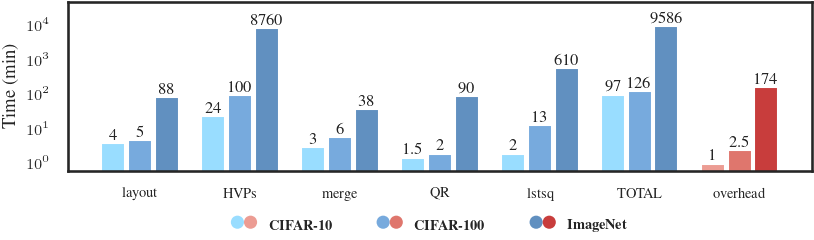

In [4]:
hw_ratio = 1 / 4

# TUEplots
plt.rcParams.update(bundles.neurips2022())
plt.rcParams.update(
    figsizes.neurips2022(
        nrows=1,
        ncols=1,
        height_to_width_ratio=hw_ratio,
    ),
)
plt.rcParams.update({"figure.constrained_layout.h_pad": 0.025})
plt.rcParams.update({"figure.constrained_layout.w_pad": 0.05})
plt.rcParams.update({"xtick.major.pad": 2})
plt.rcParams.update({"ytick.major.pad": 2})
plt.rcParams.update({"figure.dpi": 150})

fig, ax = plt.subplots()

cifar10_color = "#99DDFF"
cifar100_color = "#77AADD"
imagenet_color = "#6190C0"
cifar10_color_o = "#EC9C93"
cifar100_color_o = "#DF766D"
imagenet_color_o = "#C83D3C"


runtimes = {
    "layout": {"C10": 4, "C100": 5, "IN": 88},
    "HVPs": {"C10": int(1.2 * 20), "C100": 5 * 20, "IN": 292*30},
    "merge":  {"C10": 3, "C100": 6, "IN": 38},
    "QR":  {"C10": 1.5, "C100": 2, "IN": 90},
    "lstsq": {"C10": 2, "C100": 13, "IN": 610},
    "TOTAL":  {"C10": 97, "C100": 126, "IN": 9586},
    "overhead":  {"C10": 1, "C100": 2.5, "IN": 174},
}
colors = {
    "layout": {"C10": cifar10_color, "C100": cifar100_color, "IN": imagenet_color},
    "HVPs": {"C10": cifar10_color, "C100": cifar100_color, "IN": imagenet_color},
    "merge":  {"C10": cifar10_color, "C100": cifar100_color, "IN": imagenet_color},
    "QR":  {"C10": cifar10_color, "C100": cifar100_color, "IN": imagenet_color},
    "lstsq": {"C10": cifar10_color, "C100": cifar100_color, "IN": imagenet_color},
    "TOTAL":  {"C10": cifar10_color, "C100": cifar100_color, "IN": imagenet_color},
    "overhead":  {"C10": cifar10_color_o, "C100": cifar100_color_o, "IN": imagenet_color_o},
}


stages = ("layout", "HVPs", "merge", "QR", "lstsq", "TOTAL", "overhead")


plt_data = {stage: [runtimes[stage][prob] for prob in ("C10", "C100", "IN")] for stage in stages}
col_data = {stage: [colors[stage][prob] for prob in ("C10", "C100", "IN")] for stage in stages}


bars, _ = bar_plot(ax, plt_data, group_stretch=0.8, bar_stretch=0.9, legend=False,
         x_labels=True, label_fontsize=8, barlabel_offset=0.05, colors=col_data,
         bar_labeler=lambda k, i, s: str(round(s, 3)))

bars["layout"][0].set_label(r"\textbf{CIFAR-10}")
bars["layout"][1].set_label(r"\textbf{CIFAR-100}")
bars["layout"][2].set_label(r"\textbf{ImageNet}")

#
ax.set_ylabel("Time (min)")
ax.set_yscale("log")
ax.set_ylim(None, 50000)
# ax.set_title(r"\textbf{SKERCH Runtimes}")
# ax.legend(loc="upper left")


# Polish
legend_cols = 3
legend_height = 0.1
handles, labels = ax.get_legend_handles_labels()
handles = [MulticolorCircles([cifar10_color, cifar10_color_o], face_alpha=1),
          MulticolorCircles([cifar100_color, cifar100_color_o], face_alpha=1),
          MulticolorCircles([imagenet_color, imagenet_color_o], face_alpha=1)]

fig.legend(handles, 
           labels, 
           bbox_to_anchor=(0.81, legend_height),
           ncols=legend_cols, 
           frameon=False, 
           borderaxespad=2,
           columnspacing=3,
           handlelength=1.8,
           handler_map={MulticolorCircles: MulticolorHandler})


plt.savefig("plot_output/runtimes.pdf")
plt.show()